## Import packages

In [1]:
import CairoMakie: activate!, Figure, Axis, GridLayout, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, contourf!, Colorbar, hist, hist!, contour!, heatmap!, image, image!, Outside,
poly!, hidedecorations!, hidespines!, Label, text!, colgap!, rowgap!, Outside, colsize!, rowsize!, Relative, AxisAspect, 
density!, qqplot!, linkxaxes!, linkyaxes!, BBox, translate!, TopLeft, Label, resize_to_layout!,
hidexdecorations!, hideydecorations!, Inside, Outside, Aspect, Observable, notify, vspan!
import Makie.GeometryBasics: Rect
import Makie: available_gradients, pseudolog10, Reverse
import Measures: mm
import NaNStatistics: nanmedian, nanmaximum, nanminimum, nanmean, nanstd, movmean
import Distributed: addprocs, pmap, @everywhere
import Dates: now, Millisecond
import StatsBase: sample, mean, min, mode, fit, Histogram, std, quantile, median, skewness, kurtosis
import DataFrames: DataFrame, names, describe, append!, insertcols!, hcat!, groupby, combine, order, stack, unstack, order
import Distributions: Normal, cdf, ccdf
import Statistics: cor, quantile
import HypothesisTests: SignedRankTest, OneSampleTTest, UnequalVarianceTTest, EqualVarianceTTest, TwoSampleTTest, CorrelationTest, pvalue
import Printf: @sprintf
import Roots: find_zero, fzero, newton, Newton
import JLD: save, load
import CSV: write, read, File
import CurveFit: curve_fit, Polynomial
#import Calculus: derivative
import ForwardDiff: derivative 
import NLsolve: nlsolve
using ProgressMeter
#ENV["DATAFRAMES_ROWS"] = 5
import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
colblue=palette(:default)[1];
#c=palette(:default); c = [c[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),   #sunset,    # CMRmap  gnuplot magma plasma   thermal   linear_bmy_10_95_c78_n256 linear_bmy_10_95_c71_n256
    #Axis=(yticklabelsize=18, xticklabelsize=18,xlabelsize=20,ylabelsize=20),
    #Axis=(titlesize=24,),
    ))

In [2]:
findnearest(t::Number, A::AbstractArray) = findmin(abs.(A.-t))[2]; #find the position of t in A
findnearest(vec::AbstractArray, A::AbstractArray) = [findmin(abs.(A.-t))[2] for t in vec]; #find the positions of elements of vec in A

## Phase transition lines

In [3]:
dT = 0.001; Tblue_max = 0.5;
Tblue = dT:dT:Tblue_max;
Fblue(T) = T*acosh((1-T)/T);
ηblue = Fblue.(Tblue);
Tbluemax = Tblue[findmax(ηblue)[2]]; ηbluemax = findmax(ηblue)[1];

function find_redline(T)  
    fv(T, η, v) = -v + 0.5*sinh(2*v/T)/(cosh(2*v/T) + cosh(η/T));
    dfdv_v(T, x) = [fv(T, x[1], x[2])
                    derivative(v -> fv(T, x[1], v), x[2])];
    xguess(T) = [1-T, 0.5 - T/8];
    return T < 0.0029 ? NaN : try nlsolve(x -> dfdv_v(T, x), xguess(T)).zero[1] catch y NaN end
end

FV(    T, η, V) = 1/2*sinh(2*V/T) / (cosh(2*V/T) + cosh(η/T)) - V;
dFdV(  T, η, V) = derivative(V->FV(T, η, V), V)
d2FdV2(T, η, V) = derivative(V->dFdV(T, η, V), V)
d3FdV3(T, η, V) = derivative(V->d2FdV2(T, η, V), V)

function find_3crit_point()
    #T, eta, V
    find_3crit(x) = [FV(x[1], x[2], x[3]), dFdV(x[1], x[2], x[3]), d3FdV3(x[1], x[2], x[3])];
    xguess = [0.32, Fblue(0.32), 0];
    critpoint = nlsolve(x -> find_3crit(x), xguess).zero;  
    Tcritpoint=critpoint[1]; ηcritpoint=critpoint[2]; Vcritpoint=critpoint[3];
    return Tcritpoint, ηcritpoint
end
function find_redline_full(Tred)
    Tcritpoint = find_3crit_point()[1];
    dV_redcrit = 10^(-2);
    #red line
    dfdv_v_redcritline(T, x) = [FV(T, x[1], x[2]), dFdV(T, x[1], x[2])];
    xguess_redcritline1(T) = [find_redline(T), 0.5 - T/8];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline1(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];  Tsol = Tred; 
    Tsol, etasol, vsol = Tsol[vsol .> dV_redcrit], etasol[vsol .> dV_redcrit], vsol[vsol .> dV_redcrit];
    xguess_redcritline(T) = [find_redline(T), vsol[findnearest(T, Tsol)]];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];
    ηred = etasol;
    return ηred
end

Tcritpoint, ηcritpoint = find_3crit_point()
Tred = Tblue[0.003 .≤ Tblue .≤ Tcritpoint];
ηred = find_redline_full(Tred);
Tcritpoint, ηcritpoint 

(0.33333333333333326, 0.43898596564160547)

## Load the experimental data

In [4]:
# the experimental data for the intermixed trials. See file "SI_2armed_bandit_task_intermixed_trials_data_analysis.ipynb" for the analysis
## shown in SI tab. S4
errorg      = 0.088 ; errorbarg = 0.033 ;# I took 0.02 for heatmaps instead
errorl      = 0.243 ; errorbarl = 0.035 ; # I took 0.02 for heatmaps instead
RTgRTl      = 0.704 ; rtbar     = 0.045 ;
RTcRTw_gain = 0.815 ; rtbarg    = 0.103 ; 
RTcRTw_loss = 0.926 ; rtbarl    = 0.061 ; 

ebarg_dots  = errorbarg; # errorbar for the green dots
ebarl_dots  = errorbarl;
println("""TRIALS 34-60 after learning:
    error gain:    $(errorg) ± $(errorbarg) ± $(ebarg_dots)
    error loss:    $(errorl) ± $(errorbarl) ± $(ebarl_dots)
    RTgain/RTloss: $(RTgRTl) ± $(rtbar)
    RTc/RTw gain:  $(RTcRTw_gain) ± $(rtbarg)
    RTc/RTw loss:  $(RTcRTw_loss) ± $(rtbarl)""");

TRIALS 34-60 after learning:
error gain:    0.088 ± 0.033 ± 0.033
error loss:    0.243 ± 0.035 ± 0.035
RTgain/RTloss: 0.704 ± 0.045
RTc/RTw gain:  0.815 ± 0.103
RTc/RTw loss:  0.926 ± 0.061


## Load IIM's simulation data 

In [5]:
L = 40; # 40 10 100
IC = "ZERO"; #ZERO, RAND
ic = lowercase(IC);
file_name="./03_data_IIM_simulations/IIM1D_$(IC)_error_rt_vel_etas_0.0_1.0_Ts_0.01_0.85_bias_0.0_2.28_L_$(L)_iter_3000_234000"
df_raw = DataFrame(File(file_name*".csv"));
etas = sort(unique(df_raw.eta))[1:2:end]; ## take etas and Ts with the step of 0.02
Ts   = sort(unique(df_raw.T))[2:2:end]; Ts = Ts[Ts .≤ 0.6];
println(size(df_raw))
etas_long = sort(unique(df_raw.eta));
Ts_long   = sort(unique(df_raw.T)); Ts_long = Ts_long[Ts_long .≤ 0.6];
length(Ts), length(etas), length(Ts_long), length(etas_long)

(885753, 15)


(30, 46, 60, 91)

## Fit the errors and RTg/RTl per eta and T (eta, T -> errors -> biases -> ratio RTg/RTl)

In [6]:
## takes ~5 min to run
df_gain = df_raw[abs.(df_raw.error .- errorg) .≤ errorbarg, :];
df_loss = df_raw[abs.(df_raw.error .- errorl) .≤ errorbarl, :];
sort!(df_gain, [:eta, :T, :bias]);
sort!(df_loss, [:eta, :T, :bias]);
dfrt = DataFrame(eta = Float64[], T = Float64[], biasg = Float64[], biasl = Float64[], 
        errorg = Float64[], errorl = Float64[], rtg = Float64[], rtl = Float64[], 
        RTgRTl = Float64[], rt_cor_g = Float64[], rt_cor_l = Float64[], rt_error_g = Float64[], rt_error_l = Float64[],
        RTgRTl_cor_er_g = Float64[], RTgRTl_cor_er_l = Float64[], bias_gl = Float64[]);

@time for row_g in eachrow(df_gain)
    for row_l in eachrow(df_loss)
        if (row_g.eta == row_l.eta) && (row_g.T == row_l.T)
                
                df2 = DataFrame(eta = row_g.eta, T = row_g.T, 
                    biasg = row_g.bias, biasl = row_l.bias, 
                    errorg = row_g.error, errorl = row_l.error, 
                    rtg = row_g.rt, rtl = row_l.rt, RTgRTl = row_g.rt ./ row_l.rt,
                    rt_cor_g = row_g.rt_cor, 
                    rt_error_g =  row_g.rt_error, 
                    RTgRTl_cor_er_g = row_g.rt_cor ./ row_g.rt_error,
                    rt_cor_l = row_l.rt_cor, 
                    rt_error_l = row_l.rt_error, 
                    RTgRTl_cor_er_l = row_l.rt_cor ./ row_l.rt_error,
                    bias_gl = row_g.bias ./ row_l.bias
                )

                append!(dfrt,df2)
        end
    end
end
mean(dfrt.errorg), mean(dfrt.errorl), mean(dfrt.RTgRTl), sum(dfrt.RTgRTl .> 1)

271.481029 seconds (8.75 G allocations: 209.381 GiB, 9.46% gc time, 0.10% compilation time: 67% of which was recompilation)


(0.08700752479721842, 0.24252769787811584, 0.9355784941228928, 4114)

In [7]:
sort!(dfrt,    [:eta, :T, :biasg, :biasl]);
dfrt_dots = dfrt[(abs.(dfrt.RTgRTl .- RTgRTl) .≤ rtbar) .& (abs.(dfrt.errorg .- errorg) .≤ ebarg_dots) .& (abs.(dfrt.errorl .- errorl) .≤ ebarl_dots), :]
    
#if you want to fit the RTc/RTw gain and loss, uncomment the following lines
#dfrt_dots = dfrt_dots[(abs.(dfrt_dots.RTgRTl_cor_er_g .- RTcRTw_gain) .≤ rtbarg), :]
#dfrt_dots = dfrt_dots[(abs.(dfrt_dots.RTgRTl_cor_er_l .- RTcRTw_loss) .≤ rtbarl), :]

sort(dfrt_dots, [:T, :eta]);
size(dfrt), size(dfrt_dots)

((329164, 16), (11374, 16))

## Heatmap for ratio RTg/RTl; ϵ1_g / ϵ1_l; RTc/RTw in gain and loss

In [8]:
## we find the ratios per each eta and T on the phase diagram
RTgRTl_hmap     =  fill(NaN, length(Ts), length(etas));
RTcRTw_g_hmap   =  fill(NaN, length(Ts), length(etas));
RTcRTw_l_hmap   =  fill(NaN, length(Ts), length(etas));
biasg_hmap      =  fill(NaN, length(Ts), length(etas));
biasl_hmap      =  fill(NaN, length(Ts), length(etas));
biasgbiasl_hmap =  fill(NaN, length(Ts), length(etas));

@time for (ind_η, η) in enumerate(etas)
    for (ind_T, T) in enumerate(Ts)
        dfetaT = dfrt[(dfrt.T .== T) .& (dfrt.eta .== η), :]
        ratio_gl   = dfetaT.RTgRTl;
        ratio_cw_g = dfetaT.RTgRTl_cor_er_g;
        ratio_cw_l = dfetaT.RTgRTl_cor_er_l;
        if (length(ratio_gl) > 0) 
            RTgRTl_hmap[ ind_T, ind_η]    = mean(ratio_gl);
            biasg_hmap[ind_T, ind_η]      = mean(dfetaT.biasg);
            biasl_hmap[ind_T, ind_η]      = mean(dfetaT.biasl);
            biasgbiasl_hmap[ind_T, ind_η] = mean(dfetaT.bias_gl);
        end
        if (length(ratio_cw_g) > 0) 
            ratio = mean(ratio_cw_g);
            RTcRTw_g_hmap[ind_T, ind_η] = ratio;
        end
        if (length(ratio_cw_l) > 0) 
            ratio = mean(ratio_cw_l);
            RTcRTw_l_hmap[ind_T, ind_η] = ratio;
        end
    end
end

  0.362046 seconds (322.30 k allocations: 92.674 MiB, 39.56% compilation time)


In [9]:
#we fit the errors and RTg/RTl per eta and T (eta, T -> errors -> biases -> ratio RTg/RTl)
dfrt_dots = dfrt[(abs.(dfrt.RTgRTl .- RTgRTl) .≤ rtbar) .& (abs.(dfrt.errorg .- errorg) .≤ ebarg_dots) .& (abs.(dfrt.errorl .- errorl) .≤ ebarl_dots), :]
sort(dfrt_dots, [:T, :eta]);
dfrt_dots_unique = combine(groupby(dfrt_dots, [:eta, :T]), :RTgRTl => mean);
dfrt_dots_unique = reverse(dfrt_dots_unique);

dist = Normal();
Zscore = abs.(dfrt_dots_unique.RTgRTl_mean .- RTgRTl) ./ rtbar;
prob = 1 .- ccdf.(dist, abs.(Zscore)) .* 2;

RTgRTldots_hmap = fill(NaN, length(Ts_long), length(etas_long));
Zscoreabs_hmap  = fill(NaN, length(Ts_long), length(etas_long));

Zscore_max = 1; #   1;   0.45;

@time for (ind_η, η) in enumerate(etas_long)
    for (ind_T, T) in enumerate(Ts_long)
        dfetaT = dfrt_dots_unique[(dfrt_dots_unique.T .== T) .& (dfrt_dots_unique.eta .== η), :]
        ratio_gl   = dfetaT.RTgRTl_mean;
        if (length(ratio_gl) > 0) 
            RTgRTldots_hmap[ind_T, ind_η] = mean(ratio_gl);

            zscore = abs(mean(ratio_gl) - RTgRTl) / rtbar;
            Zscoreabs_hmap[ind_T, ind_η] = zscore ≤ Zscore_max ? abs(mean(ratio_gl) - RTgRTl) / rtbar : NaN;
        end
    end
end

## smooth the Zscoreabs_hmap
nn_smooth = 3;
Zscoreabs_hmap_smooth = movmean(Zscoreabs_hmap, nn_smooth)

size(Zscoreabs_hmap), nanmaximum(Zscoreabs_hmap), nanminimum(Zscoreabs_hmap)

  0.016049 seconds (195.66 k allocations: 9.323 MiB, 23.17% compilation time)


((60, 91), 0.9961419800066177, 0.0004357722004034849)

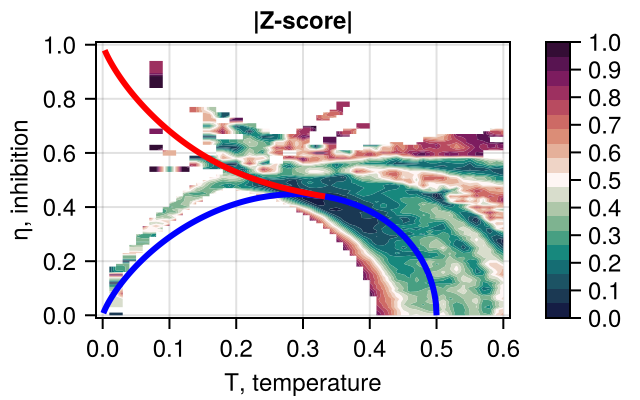

In [10]:
cmap = :curl; #:curl; bamako   #rtgl = dfrt_dots_unique.RTgRTl_mean;   #rtgl = Zscore;   #rtgl = prob;
fig = Figure(size=(320, 200), fontsize=12, figure_padding=(3, 10, 3, 3)); ax = []; cf = []; #400, 300 
push!(ax, Axis(fig[1,1][1,1], xlabel="T, temperature", ylabel="η, inhibition", title="|Z-score|"));
push!(cf, contourf!(ax[1], Ts_long, etas_long, Zscoreabs_hmap_smooth, colormap=cmap, levels=range(0, 1, length=20) ))
lines!(ax[1], Tblue, ηblue, linewidth=3, color=:blue)
lines!(ax[1], Tred,  ηred,  linewidth=3, color=:red )
xlims!(ax[1], -0.01, 0.61);   ylims!(ax[1], -0.01, 1.01); ax[1].yticks = 0:0.2:1;
Colorbar(fig[1,1][1,2], cf[1], ticks=0.0:0.1:Zscore_max); #RTgRTl-rtbar, RTgRTl+rtbar   RT(gain)/RT(loss)
fig

## DDM's predictions for RTg/RTl

In [11]:
errors = 0:0.001:0.5;

# diffusion analytics: SI eq. S56
ratTgTl_ddm(errg, errl) = errg <= errl ? (1 - 2*errg)*log(1/errl - 1) / ((1 - 2*errl)*log(1/errg - 1)) : NaN;
allrat_ddm = [ratTgTl_ddm(errorg+errorbarg, errorl+errorbarl), 
              ratTgTl_ddm(errorg-errorbarg, errorl-errorbarl), 
              ratTgTl_ddm(errorg+errorbarg, errorl-errorbarl), 
              ratTgTl_ddm(errorg-errorbarg, errorl+errorbarl)]  
TgTl_ddm = ratTgTl_ddm(errorg, errorl);              
TgTl_ddm_std = maximum(round.(abs.(allrat_ddm .- ratTgTl_ddm(errorg, errorl)), digits=3)  );
errorg, errorbarg, errorl, errorbarl, TgTl_ddm, TgTl_ddm_std

(0.088, 0.033, 0.243, 0.035, 0.7790350034262554, 0.106)

In [12]:
ratio_hmap = [ first(ratTgTl_ddm(erg, erl)) for erl in errors, erg in errors];
inds = findall(abs.(ratio_hmap .- RTgRTl) .< rtbar);

e1 = [inds[x][2] for x in 1:length(inds)]; #row
e2 = [inds[x][1] for x in 1:length(inds)]; #column

e2un = sort(unique(e2));
e1min = [minimum(e1[e2 .== el]) for el in e2un];
e1max = [maximum(e1[e2 .== el]) for el in e2un];

delta=0.002;
inds = findall(abs.(ratio_hmap .- RTgRTl) .< delta);
e1 = [inds[x][2] for x in 1:length(inds)]; #row
e2 = [inds[x][1] for x in 1:length(inds)]; #column

e2line = sort(unique(e2));
e1line = [Int64(round(mean(e1[e2 .== el]), digits=0)) for el in e2line];

## RT distributions

In [14]:
quantile_vec = 0:0.01:1;
mse(x, y) = mean((x .- y).^2);
quant_ind_mse = 2:100;

function regr_coef(x, y)
    x = x[.~isnan.(y)];
    y = y[.~isnan.(y)];
    r = cor(x, y);
    p = pvalue(CorrelationTest(x, y));

    b = r*std(y)/std(x);
    a = nanmean(y) - b*nanmean(x);
    return r, p, a, b
end

regr_coef (generic function with 1 method)

In [ ]:
## load data for RT distributions
pathname = "./03_data_IIM_simulations/";
filename = "data_RTquanltiles_Bandit_intermixed_gainloss_ERg0.088_ERl0.243_RTgRTl0.704"
data_load = load(pathname*filename*".jld");
data_load

Dict{String, Any} with 7 entries:
  "rtnormg_id"     => [0.890205, 1.07094, 0.995578, 0.629955, 1.08614, 0.963246…
  "quant_ind_mse"  => 2:100
  "rtnorml_id"     => [0.801172, 0.398669, 0.484768, 0.462962, 0.372805, 0.6004…
  "raw_datag"      => [(0.05419, [105.545, 189.834, 109.064, 158.999, 131.604, …
  "quantile_datag" => [0.431803, 0.469469, 0.484845, 0.499051, 0.504397, 0.5103…
  "quantile_datal" => [0.309227, 0.34732, 0.370478, 0.379398, 0.386947, 0.39272…
  "raw_datal"      => [(0.26814, [119.111, 132.168, 124.24, 340.811, 351.057, 1…

In [16]:
raw_datag = data_load["raw_datag"];
raw_datal = data_load["raw_datal"];
rtnormg_id = data_load["rtnormg_id"];
rtnorml_id = data_load["rtnorml_id"];
quantile_datag = data_load["quantile_datag"];
quantile_datal = data_load["quantile_datal"];
begin
    errors_gain = Float64[el[1] for el in raw_datag];
    rts_gain    =        [el[2] for el in raw_datag];
    etas_gain   = Float64[el[3] for el in raw_datag];
    Ts_gain     = Float64[el[4] for el in raw_datag];
    biases_gain = Float64[el[5] for el in raw_datag];
    iters_gain  =   Int64[el[6] for el in raw_datag];
    phases_gain =        [el[7] for el in raw_datag];
    conds_gain  =        [el[8] for el in raw_datag];

    errors_loss = Float64[el[1] for el in raw_datal];
    rts_loss    =        [el[2] for el in raw_datal];
    etas_loss   = Float64[el[3] for el in raw_datal];   
    Ts_loss     = Float64[el[4] for el in raw_datal];
    biases_loss = Float64[el[5] for el in raw_datal];
    iters_loss  =   Int64[el[6] for el in raw_datal];
    phases_loss =        [el[7] for el in raw_datal];
    conds_loss  =        [el[8] for el in raw_datal];
end
if iszero(Ts_gain .== Ts_loss) || iszero(etas_gain .== etas_loss) || iszero(iters_gain .== iters_loss) || iszero(phases_gain .== phases_loss)
    error("ERROR: parameters are not the same!")
end
VMF(V, T, η, ϵ1) = V - 1/4*sinh((4*V + ϵ1)/2/T) / (cosh((η + 2*V)/(2*T)) * cosh((-η + 2*V + ϵ1)/(2*T)));
VMF_cor(T, η, ϵ1) = try fzero(V -> VMF(V, T, η, ϵ1),  0.45) catch y NaN end; #RT_theory = L / VMF_cor / mean(RTs);

df_sim = DataFrame(
    eta = etas_gain, T = Ts_gain, phase = phases_gain, biasg = biases_gain, biasl = biases_loss,
    errorg = errors_gain, errorl = errors_loss, iterations = iters_gain, rtg = rts_gain, rtl = rts_loss)

    df_sim.RTmeang    = [mean(el) for el in df_sim.rtg];
    df_sim.RTmeanl    = [mean(el) for el in df_sim.rtl];
    df_sim.RTstdg     = [std(el) for el in df_sim.rtg];
    df_sim.RTstdl     = [std(el) for el in df_sim.rtl];
    df_sim.rtnormg    = [el ./ mean(el) for el in df_sim.rtg];
    df_sim.rtnorml    = [el ./ mean(el) for el in df_sim.rtl];
    df_sim.Rtmedg     = [median(el) for el in df_sim.rtg];
    df_sim.Rtmedl     = [median(el) for el in df_sim.rtl];

    df_sim.skewnessg  = [skewness(el) for el in df_sim.rtg];
    df_sim.skewnessl  = [skewness(el) for el in df_sim.rtl];
    df_sim.kurtosisg  = [kurtosis(el) for el in df_sim.rtg];
    df_sim.kurtosisl  = [kurtosis(el) for el in df_sim.rtl];
    df_sim.quantileg  = [quantile(el, quantile_vec) for el in df_sim.rtnormg];
    df_sim.quantilel  = [quantile(el, quantile_vec) for el in df_sim.rtnorml];

    df_sim.VMFcorg    = [VMF_cor(el.T, el.eta, el.biasg) for el in eachrow(df_sim)];
    df_sim.VMFcorl    = [VMF_cor(el.T, el.eta, el.biasl) for el in eachrow(df_sim)];
    df_sim.RT_MFg     = L ./ df_sim.VMFcorg;
    df_sim.RT_MFl     = L ./ df_sim.VMFcorl;
    df_sim.RT_MFnormg = df_sim.RT_MFg ./ df_sim.RTmeang;
    df_sim.RT_MFnorml = df_sim.RT_MFl ./ df_sim.RTmeanl;

    df_sim.RTgRTl     = df_sim.RTmeang ./ df_sim.RTmeanl;

    df_sim.Zscore_RTgRTl = (df_sim.RTgRTl .- RTgRTl) ./ rtbar;
    df_sim.Zscore_errorg = (df_sim.errorg .- errorg) ./ errorbarg;
    df_sim.Zscore_errorl = (df_sim.errorl .- errorl) ./ errorbarl;

    df_sim.mse_g = [mse(quantile_datag[quant_ind_mse], row.quantileg[quant_ind_mse]) for row in eachrow(df_sim)];
    df_sim.mse_l = [mse(quantile_datal[quant_ind_mse], row.quantilel[quant_ind_mse]) for row in eachrow(df_sim)];
    df_sim.mse   = df_sim.mse_g + df_sim.mse_l;

    #df_sim.Zscore_RTgRTl_orig = [(dfrt_dots[(dfrt_dots.eta .== row.eta) .&& (dfrt_dots.T .== row.T) .&& (dfrt_dots.biasg .== row.biasg) .&&
    #(dfrt_dots.biasl .== row.biasl), :RTgRTl][1] .- RTgRTl) ./ rtbar for row in eachrow(df_sim)];
#sort!(df_sim, [order(:phase, rev=true), :T, :eta, :biasg, :biasl]);
println(size(df_sim), names(df_sim))

(76, 37)["eta", "T", "phase", "biasg", "biasl", "errorg", "errorl", "iterations", "rtg", "rtl", "RTmeang", "RTmeanl", "RTstdg", "RTstdl", "rtnormg", "rtnorml", "Rtmedg", "Rtmedl", "skewnessg", "skewnessl", "kurtosisg", "kurtosisl", "quantileg", "quantilel", "VMFcorg", "VMFcorl", "RT_MFg", "RT_MFl", "RT_MFnormg", "RT_MFnorml", "RTgRTl", "Zscore_RTgRTl", "Zscore_errorg", "Zscore_errorl", "mse_g", "mse_l", "mse"]


In [17]:
# HERE FILTER DF_SIM -- the two errors are within the error bars
println(size(df_sim))
df_sim = df_sim[((df_sim.errorg .- errorg).^2 .≤ errorbarg^2) .&& ((df_sim.errorl .- errorl) .^2 .≤ errorbarl^2), :];
println(size(df_sim))

## Low MSE: Z-score < 0.1 and MSE < 0.015
df_lowmse = df_sim[abs.(df_sim.Zscore_RTgRTl) .≤ 0.1 .&& abs.(df_sim.mse) .≤ 0.015, :][1, :];
df_highmse = df_sim[df_sim.T .== 0.6, :][1, :];

size(df_lowmse), size(df_highmse), abs.(df_lowmse.Zscore_RTgRTl), abs.(df_lowmse.mse)

(76, 37)
(42, 37)


((37,), (37,), 0.030896586641038226, 0.00973543291624854)

## Plot everything: SI fig. S15(a,b,c,e,f); S16(a)

In [18]:
function add_box_inset(fig; bgcolor=:white, #snow2
    left=100, right=250, bottom=200, top=300, labelsize = 10)
    inset_box = Axis(fig, bbox=BBox(left, right, bottom, top), xticklabelsize=labelsize, yticklabelsize=labelsize, backgroundcolor=bgcolor)
    translate!(inset_box.scene, 0, 0, 100)  # bring content upfront
    hidedecorations!(inset_box, grid = true, label = false, ticklabels = true, ticks = true, minorgrid = false, minorticks = false)
    return inset_box
end

add_box_inset (generic function with 1 method)

r=0.8648
p=1.55e-13


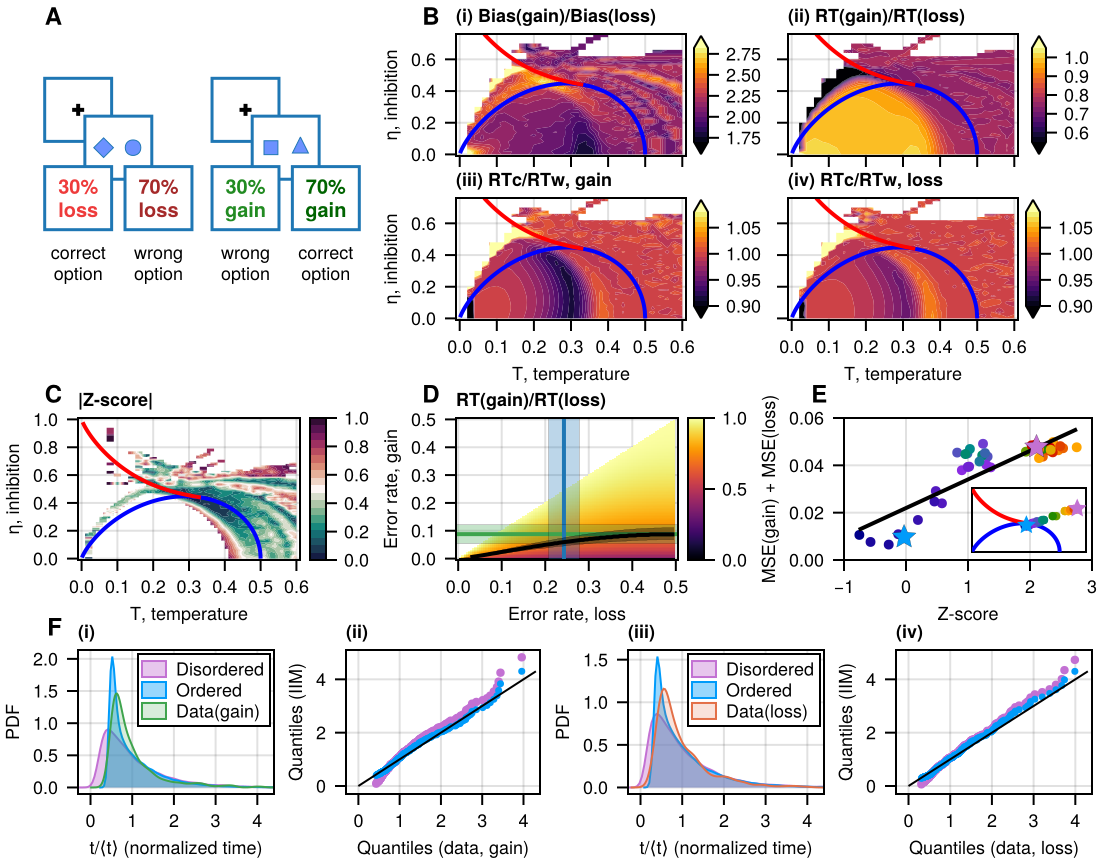

In [19]:
fig = Figure(size=(550, 430), fontsize=9, figure_padding=(2, 4, 2, 1));  #400, 300
begin  # A
    fonstsize_cond = 10; masize_shapes = 11; msize_cross = 8;
    ga = fig[1, 1] = GridLayout();
    axa = Axis(ga[1, 1], aspect = AxisAspect(2), alignmode = Outside(-20) )
        poly!(axa, [Rect(0,   1.4, 1, 1)], color=:white, strokecolor=c[1], strokewidth = 1.5) 
        poly!(axa, [Rect(0.6, 0.8, 1, 1)], color=:white, strokecolor=c[1], strokewidth = 1.5) 
        poly!(axa, [Rect(0,   0,   1, 1)], color=:white, strokecolor=c[1], strokewidth = 1.5) 
        poly!(axa, [Rect(1.2, 0,   1, 1)], color=:white, strokecolor=c[1], strokewidth = 1.5) 
        scatter!(axa, [0.5],  [1.9], marker=:cross,     markersize=msize_cross, color=:black) 
        scatter!(axa, [0.88], [1.3], marker=:diamond,   markersize=masize_shapes, color=(:royalblue1, 0.8), strokecolor=c[1], strokewidth=0.5)
        scatter!(axa, [1.32], [1.3], marker=:circle,    markersize=masize_shapes, color=(:royalblue1, 0.8), strokecolor=c[1], strokewidth=0.5)
        text!(axa, [0.5], [0.5], text="30%\nloss", color=:brown2, fontsize=fonstsize_cond, font=:bold, align = (:center, :center))
        text!(axa, [1.7], [0.5], text="70%\nloss", color=:brown,  fontsize=fonstsize_cond, font=:bold, align = (:center, :center))
    gap=2.5
        poly!(axa, [Rect(gap,   1.4, 1, 1)],   color=:white, strokecolor=c[1], strokewidth = 1.5)
        poly!(axa, [Rect(0.6+gap, 0.8, 1, 1)], color=:white, strokecolor=c[1], strokewidth = 1.5)
        poly!(axa, [Rect(gap,   0,   1, 1)],   color=:white, strokecolor=c[1], strokewidth = 1.5)
        poly!(axa, [Rect(1.2+gap, 0,   1, 1)], color=:white, strokecolor=c[1], strokewidth = 1.5)
        scatter!(axa, [0.5+gap],  [1.9], marker=:cross,     markersize=msize_cross, color=:black) 
        scatter!(axa, [0.88+gap], [1.3], marker=:rect,      markersize=masize_shapes, color=(:royalblue1, 0.8), strokecolor=c[1], strokewidth=0.5)
        scatter!(axa, [1.32+gap], [1.3], marker=:utriangle, markersize=masize_shapes, color=(:royalblue1, 0.8), strokecolor=c[1], strokewidth=0.5)
        text!(axa, [0.5+gap], [0.5], text="30%\ngain", color=:forestgreen, fontsize=fonstsize_cond, font=:bold, align = (:center, :center))
        text!(axa, [1.7+gap], [0.5], text="70%\ngain", color=:darkgreen,   fontsize=fonstsize_cond, font=:bold, align = (:center, :center))

        xlims!(axa, [-0.1, 0.1+2.2+gap]);  #  ax[1].xticks=0:0.4:10;
        ylims!(axa, [-0.1, 2.5]);          #  ax[1].yticks=0:0.2:2.5;
        axa.xticks = ([0.5, 1.7, 3, 4.2], ["correct\noption", "wrong\noption", "wrong\noption", "correct\noption"])
        axa.yticks = [-100]
        hidedecorations!.(axa, ticklabels = false); hidespines!.(axa)
end
begin  # B
    eta_end = 0.76; cf = []; #400, 300 
    gb = fig[1, 2:3] = GridLayout(); cmap = :curl; axb=[]; cf = [];  
    push!(axb, Axis(gb[1,1], titlealign = :left, title = "(i) Bias(gain)/Bias(loss)", ylabel="η, inhibition")) # title="(b)1 Bias(gain)/Bias(loss)"));
    push!(axb, Axis(gb[1,3], titlealign = :left, title = "(ii) RT(gain)/RT(loss)", )) # title="(b)2 RT(gain)/RT(loss)"));
    push!(axb, Axis(gb[2,1], titlealign = :left, title = "(iii) RTc/RTw, gain", xlabel="T, temperature", ylabel="η, inhibition", ))  #  title="(b)3 RTc/RTw, gain"));
    push!(axb, Axis(gb[2,3], titlealign = :left, title = "(iv) RTc/RTw, loss", xlabel="T, temperature", ))  # title="(b)4 RTc/RTw, loss"));
    push!(cf, contourf!(axb[1], Ts, etas, biasgbiasl_hmap, extendlow=:auto, extendhigh=:auto, levels=range(1.7, 2.82, length = 20))); # 0.88:0.05:1.23,  #levels=range(3, 7, length = 20)
    push!(cf, contourf!(axb[2], Ts, etas, RTgRTl_hmap  ,   extendlow=:auto, extendhigh=:auto, levels=range(0.55, 1.05, length = 20)));
    push!(cf, contourf!(axb[3], Ts, etas, RTcRTw_g_hmap,   extendlow=:auto, extendhigh=:auto, levels=range(0.9, 1.08, length = 20),)); # 0.88:0.05:1.23, 
    push!(cf, contourf!(axb[4], Ts, etas, RTcRTw_l_hmap,   extendlow=:auto, extendhigh=:auto, levels=range(0.9, 1.08, length = 20),)); # 0.88:0.05:1.23, 
    [Colorbar(gb[1,2*i],     cf[i], size = 7, alignmode = Outside()) for i in 1:2];
    [Colorbar(gb[2,(i-2)*2], cf[i], size = 7, alignmode = Outside()) for i in 3:4];
    [lines!(axi, Tblue, ηblue, linewidth=2, color=:blue) for axi in axb];  #  label="1-order tr-n", 
    [lines!(axi, Tred,  ηred,  linewidth=2, color=:red ) for axi in axb];  #  label="2-order tr-n", 
    [xlims!(axi,[-0.01, 0.61]) for axi in axb]; [ylims!(axi,[-0.01, eta_end]) for axi in axb]; [axi.yticks=0:0.2:1 for axi in axb]
    #hidedecorations!(axb[1], grid = false, label = true, xticklabel = true, xticks = true, minorgrid = false, minorticks = false)
    hidexdecorations!(axb[1], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
    hidexdecorations!(axb[2], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
    hideydecorations!(axb[2], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
    hideydecorations!(axb[4], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
end
begin  # C
    gc = fig[2,1] = GridLayout(); cmap = :curl; cf = [];  
    axc = Axis(gc[1,1], xlabel="T, temperature", ylabel="η, inhibition", titlealign = :left, title = "|Z-score|") #, title="(c) |Z-score|") #, aspect = AxisAspect(1.4))#, alignmode = Outside(50)));
    push!(cf, contourf!(axc, Ts_long, etas_long, Zscoreabs_hmap_smooth, colormap=cmap, levels=range(0, 1, length=20) ))  # colorrange = (0, 1), 
    lines!(axc, Tblue, ηblue, linewidth=2, color=:blue)
    lines!(axc, Tred,  ηred,  linewidth=2, color=:red )
    xlims!(axc, -0.01, 0.61);   ylims!(axc, -0.01, 1.01); axc.yticks = 0:0.2:1;
    Colorbar(gc[1,2], cf[1], ticks=0.0:0.2:1, width = 8)#, height=120, tellheight=true)#, height=120, tellheight=false); 
end
begin  # D 
    gd = fig[2, 2] = GridLayout(); cf = [];  
    axd =  Axis(gd[1,1], xlabel="Error rate, loss", ylabel="Error rate, gain", titlealign = :left, title = "RT(gain)/RT(loss)")#, aspect = AxisAspect(1.3)#, alignmode = Outside(50)));
    push!(cf, heatmap!(axd, errors[1:5:end], errors[1:5:end], ratio_hmap[1:5:end, 1:5:end]))
        band!(  axd, [errorl-errorbarl, errorl+errorbarl], [-1, -1], [1, 1], color=(c[1], 0.3), overdraw=true) #, strokecolor=:black)
        band!(  axd, [-1, 1], [errorg-errorbarg, errorg-errorbarg], [errorg+errorbarg, errorg+errorbarg], color=(c[2], 0.3))
        hlines!(axd, [errorg], linewidth=2, color=c[2])
        vlines!(axd, [errorl], linewidth=2, color=c[1])
        hlines!(axd, [errorg-errorbarg; errorg+errorbarg], linewidth=0.1, color=:black)
        vlines!(axd, [errorl-errorbarl; errorl+errorbarl], linewidth=0.1, color=:black)
        band!( axd, errors[e2un][1:5:end],   errors[e1min][1:5:end], errors[e1max][1:5:end], color=(:black, 0.35))
        lines!(axd, errors[e2line][1:5:end], errors[e1line][1:5:end], linewidth=2,   color=:black)
        lines!(axd, errors[e2un][1:5:end],   errors[e1min][1:5:end],  linewidth=0.1, color=:black)
        lines!(axd, errors[e2un][1:5:end],   errors[e1max][1:5:end],  linewidth=0.1, color=:black)
    
    xlims!(axd, -0.005, 0.505); axd.xticks = 0:0.1:0.5;
    ylims!(axd, -0.005, 0.505); axd.yticks = 0:0.1:0.5;
    Colorbar(gd[1,2], cf[1], width = 8 ) 
end
if true # E
    colorrange = [minimum(df_sim.T), maximum(df_sim.T)]; cmap = :darktest   #:Set1_3)  # :nipy_spectral   # :brg  :phase :gnuplot  :jet  :rainbow   :curl  ;
    ge = fig[2,3] = GridLayout(); ax = [];
    #push!(ax, Axis(fig[1,1], xlabel="T, temperature", ylabel="η, inhibition", title="Error_g=$(errorg)±$(round(errorbarg*erbar_coef, digits=3)), Error_l=$(errorl)±$(round(errorbarl*erbar_coef, digits=3))\nRTg/RTl=$(RTgRTl)±$(round(rtbar * rtbar_coef, digits=3))"));
    push!(ax, Axis(ge[1, 1], ylabel="MSE(gain) + MSE(loss)", xlabel="Z-score")) #,   title=" MSE vs. Z-score vs. ($(size(df_sim, 1)) points)"));

        scatter!(ax[1], df_sim.Zscore_RTgRTl, df_sim.mse, markersize=7, color=df_sim.T, colorrange=colorrange, colormap=cmap, strokewidth=0.01);

        fit_power = 1; y = df_sim.mse; x = df_sim.Zscore_RTgRTl; cor_coef, pcor, a, b = regr_coef(x, y); str_pcor = @sprintf("%.2e", pcor)
        fit_func = curve_fit(Polynomial, x, y, fit_power); x_fit = minimum(x)-0.01 :0.01:maximum(x) + 0.01; y_fit = fit_func.(x_fit);
        lines!(ax[1], x_fit, y_fit, linewidth=2, color=:black, label="r=$(round.(cor_coef, digits=4))\np=$(str_pcor)")

        scatter!(ax[1], df_lowmse.Zscore_RTgRTl,  df_lowmse.mse,  markersize=14, color=colblue, marker=:star5, strokewidth=0.1);   #   :darkturquoise,
        scatter!(ax[1], df_highmse.Zscore_RTgRTl, df_highmse.mse, markersize=14, color=c[4],    marker=:star5, strokewidth=0.1);   #   :magenta,          

        xlims!(ax[1], -1, 3); ylims!(ax[1], 0.0, 0.06); ax[1].yticks = 0:0.02:0.06; #ax[1].xticks = -1:1:3;
    if true
        inset_ax2 = add_box_inset(fig; bgcolor=(:white, 1), left=486, right=543, bottom=154, top=186, labelsize=8);
            lines!(  inset_ax2, Tblue, ηblue, linewidth=2, color=:blue)
            lines!(  inset_ax2, Tred,  ηred,  linewidth=2, color=:red )
            scatter!(inset_ax2, df_sim.T,     df_sim.eta,     markersize=6,  color=df_sim.T, colorrange=colorrange, colormap=cmap, strokewidth=0.01);
            scatter!(inset_ax2, df_lowmse.T,  df_lowmse.eta,  markersize=11, color=colblue, marker=:star5, strokewidth=0.01);   #   :darkturquoise,
            scatter!(inset_ax2, df_highmse.T, df_highmse.eta, markersize=11, color=c[4],    marker=:star5, strokewidth=0.01);   #   :magenta,  

            xlims!(inset_ax2, 0, 0.65); inset_ax2.xticks = 0:0.2:1;  
            ylims!(inset_ax2, 0.0, 1); inset_ax2.yticks = 0:0.5:1;
    end
    println("r=$(round.(cor_coef, digits=4))\np=$(str_pcor)")
end
if true # F
    qqtailmax = 4.3; ndigits_r = 4;  col_vline = [:darkblue, :darkgreen, :darkred];  color_vec = [c[4], colblue];

    gf = fig[3, 1:3] = GridLayout(); ax = [];    
        push!(ax, Axis(gf[1,1], xlabel="t/⟨t⟩ (normalized time)", ylabel="PDF",             alignmode = Inside() , titlealign = :left, title = "(i)"  ));
        push!(ax, Axis(gf[1,2], xlabel="Quantiles (data, gain)", ylabel="Quantiles (IIM)",  alignmode = Inside() , titlealign = :left, title = "(ii)" )); # title="η=$(η) T=$(T), ϵ₁=$(biasg)"
        push!(ax, Axis(gf[1,3], xlabel="t/⟨t⟩ (normalized time)", ylabel="PDF",             alignmode = Inside() , titlealign = :left, title = "(iii)"  ));
        push!(ax, Axis(gf[1,4], xlabel="Quantiles (data, loss)", ylabel="Quantiles (IIM)",  alignmode = Inside() , titlealign = :left, title = "(iv)" )); #title="η=$(η) T=$(T), ϵ₁=$(biasl)"
        
    for (ii, row) in enumerate([df_highmse, df_lowmse])
        η = round(row.eta, digits=ndigits_r); T = round(row.T, digits=ndigits_r); phase = row.phase; Z = row.Zscore_RTgRTl;
        biasg = round(row.biasg, digits=ndigits_r); biasl = round(row.biasl, digits=ndigits_r);
        mse_g = mse(quantile_datag[quant_ind_mse], row.quantileg[quant_ind_mse]);
        mse_l = mse(quantile_datal[quant_ind_mse], row.quantilel[quant_ind_mse]);
        col = color_vec[ii];
        if mse_g != row.mse_g || mse_l != row.mse_l
            println("ERROR: gain $(mse_g) != $(row.mse_g) or loss $(mse_l) != $(row.mse_l)")
        end
            density!(ax[1], row.rtnormg, npoints = 200, color=(col, 0.4), strokecolor=col, strokewidth=1, label="$(phase=="ordered" ? "Ordered" : phase=="disordered" ? "Disordered" : "")");  #Z=$(round(Z, digits=4))  T=$(T),η=$(η)
            density!(ax[3], row.rtnorml, npoints = 200, color=(col, 0.4), strokecolor=col, strokewidth=1, label="$(phase=="ordered" ? "Ordered" : phase=="disordered" ? "Disordered" : "")");
            qqplot!(ax[2], rtnormg_id, row.rtnormg, color=col, markersize = 7-ii, strokewidth=0.0, label="MSE=$(round(mse_g, digits=3))") #qqline = :identity,
            qqplot!(ax[4], rtnorml_id, row.rtnorml, color=col, markersize = 7-ii, strokewidth=0.0, label="MSE=$(round(mse_l, digits=3))") #qqline = :identity,
    end

    density!(ax[1], rtnormg_id,  npoints = 200, color=(c[2], 0.2), strokecolor=c[2], strokewidth=1, label="Data(gain)");
    density!(ax[3], rtnorml_id,  npoints = 200, color=(c[3], 0.2), strokecolor=c[3], strokewidth=1, label="Data(loss)");
    [lines!( axi, 0:0.1:4.3, x -> x, color=:black, linewidth=1) for axi in ax[[2, 4]]];

    [xlims!(axi, (-0.3, qqtailmax+0.1)) for axi in ax]; 
        [ylims!(axi, -0.3, 5.1) for axi in ax[[2,4]]] ; 
        linkyaxes!(ax[4], ax[2]);
        colgap!(gd, 4); rowgap!(gd, 8);  #[axi.yscale = pseudolog10 for axi in ax]  ##ax[1].yscale = pseudolog10 
        axislegend(ax[1], position=:rt, height=38, rowgap=0, patchsize = (12, 8), margin=(0,2,0,2), padding=(2,3,0,0))# width=152)  #fig[1,1] = Legend(fig, ax[2] )
        axislegend(ax[3], position=:rt, height=38, rowgap=0, patchsize = (12, 8), margin=(0,2,0,2), padding=(2,3,0,0))# width=152)  #fig[1,1] = Legend(fig, ax[2] )
end
colgap!(fig.layout, 7); rowgap!(fig.layout, -5); rowgap!(fig.layout,1, -1)
    colgap!(gb, 10); rowgap!(gb, 2);
    colgap!(gb, 1, 4); colgap!(gb, 3, 4); 
    colgap!(gc, 5 ); rowgap!(gc, 5 ); 
    colgap!(gd, 5 ); rowgap!(gd, 5 );
    colgap!(gf, 7 ); rowgap!(gf, 5 );
    rowsize!(fig.layout, 1, Relative(0.5))
for (label, layout) in zip(["A", "B", "C", "D", "E", "F"], [ga, gb, gc, gd, ge, gf])
    Label(layout[1, 1, TopLeft()], label,
            fontsize = 12,
            font = :bold,
            padding = (label=="A" || label=="B") ? (0, 8, 2, 0) : (0, 8, 5, 0),
            halign = :right)
end
resize_to_layout!(fig)
fig

## IIM in the disordered phase vs. near tricritical point vs. DDM vs. data: SI fig. S15(d)

Here show the plots, while the statistical analysis is shown in "SI_2armed_bandit_task_intermixed_trials_data_analysis.ipynb"

In [21]:
rtgrtl_ddm = Array{Float64, 1}();
rtgrtl_rnt = Array{Float64, 1}();

function isddm(T, η)
    #(row.T > 0.5) || (0.3 < row.T ≤ 0.5 && row.eta > F(row.T))  ## # || (row.T < 0.3 && row.eta > ηred[findnearest(row.T, Tred)])
    if T > 0.5
        return true
    elseif 0.3 < T ≤ 0.5 && η > Fblue(T)
        return true
    else
        return false
    end
end
function isneartricrit(T, η)
    dT=0.05; dη=0.05;
    if Tcritpoint - dT ≤ T ≤ Tcritpoint + dT && ηcritpoint - dη ≤ η ≤ ηcritpoint + dη
        return true
    else
        return false
    end
end

for row in eachrow(dfrt)
    if isddm(        row.T, row.eta) push!(rtgrtl_ddm, row.RTgRTl) end
    if isneartricrit(row.T, row.eta) push!(rtgrtl_rnt, row.RTgRTl) end
end
nanmean(rtgrtl_ddm), nanstd(rtgrtl_ddm), size(rtgrtl_ddm), nanmean(rtgrtl_rnt), nanstd(rtgrtl_rnt), size(rtgrtl_rnt)

(0.7620017273357474, 0.047255054185445136, (7418,), 0.7563554829268574, 0.06314283561384848, (3020,))

In [22]:
## define the blue (RnT) and purple (DDM) areas on the phase diagram
deta_ddm = 0.05;
etaddm_min(T) = T > 0.65 ? 0 :
(0.5 < T ≤ 0.65) ?  deta_ddm : 
(0.3 < T ≤ 0.5)  ? Fblue(T) + deta_ddm :
(0.1 < T ≤ 0.3)  ? ηred[findnearest(T, Tred)] + deta_ddm : NaN;
etaddm_max(T) = T > 0.65 ? 1 :
(0.5 < T ≤ 0.65) ?  1 :
(0.3 < T ≤ 0.5)  ? 1 :
(0.1 < T ≤ 0.3)  ? 1 : NaN;

rtgrtl_df = filter(row -> begin  #(row.T < 0.8) && 
                            row.T > 0.65 || 
                            (0.5 < row.T ≤ 0.65 && row.eta > deta_ddm) || 
                            (0.3 < row.T ≤ 0.5  && row.eta > Fblue(row.T) + deta_ddm)   ||
                            (0.1 < row.T ≤ 0.3  && row.eta > ηred[findnearest(row.T, Tred)] + deta_ddm)
                          end, dfrt);
rtgrtl_ddm = rtgrtl_df.RTgRTl;
Tddm = sort(unique(rtgrtl_df.T));
nanmean(rtgrtl_df.RTgRTl), nanstd(rtgrtl_df.RTgRTl), size(rtgrtl_df.RTgRTl)                  

(0.7637134387969553, 0.046363190415712636, (6917,))

In [23]:
# diffusion analytics 
ratTgTl_ddm(errg, errl) = (1 - 2*errg)*log(1/errl - 1) / ((1 - 2*errl)*log(1/errg - 1));
allrat_ddm = [ratTgTl_ddm(errorg+errorbarg, errorl+errorbarl), 
              ratTgTl_ddm(errorg-errorbarg, errorl-errorbarl), 
              ratTgTl_ddm(errorg+errorbarg, errorl-errorbarl), 
              ratTgTl_ddm(errorg-errorbarg, errorl+errorbarl)]  
TgTl_ddm = ratTgTl_ddm(errorg, errorl);              
TgTl_ddm_std = maximum(round.(abs.(allrat_ddm .- ratTgTl_ddm(errorg, errorl)), digits=3)  );
TgTl_ddm, TgTl_ddm_std

(0.7790350034262554, 0.106)

(0.7301497309413235, 0.05438772870440981, (1723,))


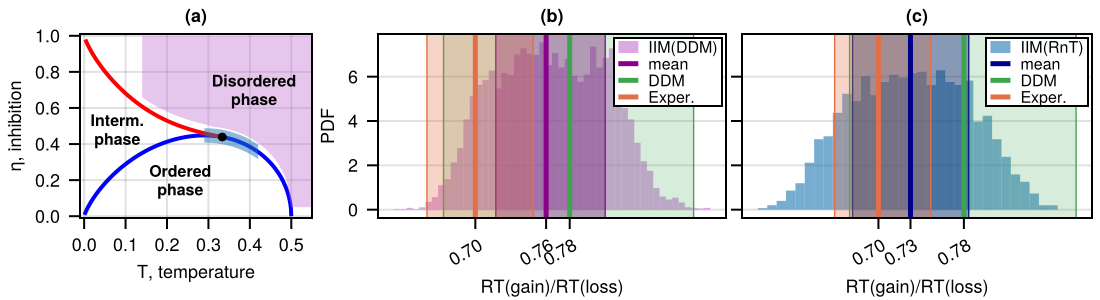

In [24]:
deta = 0.04; dT = 0.04;
etamin_rnt(T) = Fblue(T) - deta;
etamax_rnt(T) = Fblue(T) + deta;
Tminmax = floor(Tcritpoint-dT, digits=2) : 0.01 : ceil(Tcritpoint + 2*dT, digits=2) ;
rtgrtl_df_rnt = filter(row -> 
begin  
    floor(Tcritpoint-dT, digits=2) ≤ row.T ≤ ceil(Tcritpoint + dT, digits=2)  &&  etamin_rnt(row.T) ≤ row.eta ≤ etamax_rnt(row.T)
end, dfrt);
rtgrtl_rnt = rtgrtl_df_rnt.RTgRTl;
println((nanmean(rtgrtl_df_rnt.RTgRTl), nanstd(rtgrtl_df_rnt.RTgRTl), size(rtgrtl_df_rnt.RTgRTl) ) ) 

fig = Figure(size=(550, 150), fontsize=9, figure_padding=(3,4,3,3)); ax = []; 
push!(ax, Axis(fig[1,1], xlabel="T, temperature", ylabel="η, inhibition", title="(a)")) #aspect = AxisAspect(1.5)));
    lines!(ax[1], Tblue, ηblue, color=:blue, linewidth=2);
    lines!(ax[1], Tred,  ηred,  color=:red,  linewidth=2);
    band!(ax[1], Tddm,    etaddm_min.(Tddm   ), etaddm_max.(Tddm   ), color=(c[4], 0.4));
    band!(ax[1], Tminmax, etamin_rnt.(Tminmax), etamax_rnt.(Tminmax), color=(c[1], 0.5), );
    scatter!(ax[1], [Tcritpoint],[ηcritpoint], marker=:circle, markersize=6, color=:black, strokewidth=0.1);
    text!(ax[1], [0.08, 0.232, 0.41], [0.48, 0.2, 0.7], text=["Interm.\nphase", "Ordered\nphase", "Disordered\nphase"], color=:black, font=:bold, fontsize=8, align=(:center, :center)) #font=:bold,
    xlims!(ax[1], [-0.01, 0.55]);  ax[1].xticks = 0:0.1:1;
    ylims!(ax[1], [-0.01, 1.01]);  ax[1].yticks = 0:0.2:1;
push!(ax, Axis(fig[1,2], xlabel="RT(gain)/RT(loss)", ylabel="PDF", title="(b)", xticklabelrotation=pi/6)) #, title="RTg/RTl ratio in the disordered phase"));
    hist!(ax[end], rtgrtl_ddm, bins=50, color=(c[4], 0.6), normalization=:pdf, label="IIM(DDM)");
    vspan!(ax[end], [nanmean(rtgrtl_ddm) - nanstd(rtgrtl_ddm)], [nanmean(rtgrtl_ddm) + nanstd(rtgrtl_ddm)], color=(:darkmagenta, 0.4), strokewidth=0.7, strokecolor = :darkmagenta);
    vspan!(ax[end], [TgTl_ddm - TgTl_ddm_std], [TgTl_ddm + TgTl_ddm_std], color=(c[2], 0.2), strokewidth=0.7, strokecolor = c[2]);
    vspan!(ax[end], [RTgRTl - rtbar], [RTgRTl + rtbar], color=(c[3], 0.3), strokewidth=0.7, strokecolor=c[3]);
    vlines!(ax[end], [round(nanmean(rtgrtl_ddm), digits=2)], linewidth=2.5, label="mean", color=:darkmagenta);
    vlines!(ax[end], [round(nanmean(TgTl_ddm),   digits=2)], linewidth=2.5, label="DDM", color=c[2]);
    vlines!(ax[end], [round(nanmean(RTgRTl),     digits=2)], linewidth=2.5, label="Exper.", color=c[3]);
    ax[end].xticks = sort([round(nanmean(RTgRTl), digits=2), round(nanmean(TgTl_ddm), digits=2), round(nanmean(rtgrtl_ddm), digits=2)]);
    axislegend(ax[end], position=:rt, padding=(2,2,0,0), margin=(2,2,2,2), rowgap=-1, patchsize=(10,6), labelsize=8)# margin=(10,3,3,0),  padding=(3,3,0,0),  tellheight=true, nbanks=1, height=68, 
push!(ax, Axis(fig[1,3], xlabel="RT(gain)/RT(loss)", title="(c)", xticklabelrotation=pi/6)) #, title="RTg/RTl ratio in the disordered phase"));
    hist!(ax[end], rtgrtl_rnt, bins=32, color=(c[1], 0.6), normalization=:pdf, label="IIM(RnT)");
    vspan!(ax[end], [nanmean(rtgrtl_rnt) - nanstd(rtgrtl_rnt)], [nanmean(rtgrtl_rnt) + nanstd(rtgrtl_rnt)], color=(:darkblue, 0.4), strokewidth=0.7, strokecolor = :darkblue);
    vspan!(ax[end], [TgTl_ddm - TgTl_ddm_std], [TgTl_ddm + TgTl_ddm_std], color=(c[2], 0.2), strokewidth=0.7, strokecolor = c[2]);
    vspan!(ax[end], [RTgRTl - rtbar], [RTgRTl + rtbar], color=(c[3], 0.3), strokewidth=0.7, strokecolor=c[3]);
    vlines!(ax[end], [round(nanmean(rtgrtl_rnt), digits=2)], linewidth=2.5, label="mean", color=:darkblue);
    vlines!(ax[end], [round(nanmean(TgTl_ddm),   digits=2)], linewidth=2.5, label="DDM", color=c[2]);
    vlines!(ax[end], [round(nanmean(RTgRTl),     digits=2)], linewidth=2.5, label="Exper.", color=c[3]);
    ax[end].xticks = sort([round(nanmean(RTgRTl), digits=2), round(nanmean(TgTl_ddm), digits=2), round(nanmean(rtgrtl_rnt), digits=2)]);
    axislegend(ax[end], position=:rt, padding=(2,2,0,0), margin=(2,2,2,2), rowgap=-1, patchsize=(10,6), labelsize=8)# margin=(10,3,3,0),  padding=(3,3,0,0),  tellheight=true, nbanks=1, height=68, 
colgap!(fig.layout, 3); linkyaxes!(ax[2], ax[3]);   colsize!(fig.layout, 1, Relative(0.25)); #linkxaxes!(ax[2], ax[3]);
hideydecorations!(ax[3], label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false)
fig